# Atmosperhic Neutrino Flux from MCEq

This script evaluates the splines of pre-computed tables. The tables are generated using pisa/scripts/create_barr_sys_tables_mceq.py. 

The splines with label "numu", "anumu", "nue", "anue" is the nominal flux as calculated with MCEq.
The systematic flux, i.e. the flux with uncertainties accounted for is taken 'relative' to the nominal flux, meaning that the systematic flux plus (minus) one sigma is the nominal flux plus (minus) the systematic flux.

The scheme is further explained in Chapter 7 and 8 of my thesis (ask Jason for link). 

In [1]:
#basic imports and ipython setup
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import cPickle as pickle
from bz2 import BZ2File
from scipy.interpolate import RectBivariateSpline

In [77]:
# Define the priors of the Barr variables as determined by Barr 2006 arXiv:0611266

barr_val = {
    'a': 0.1,
    'b': 0.3,
    'c': 0.1,
    'd': 0.3,
    'e': 0.05,
    'f': 0.1,
    'g': 0.3,
    'h': 0.15,
    'w': 0.4,
    'x': 0.1,
    'y': 0.3,
}

def flux(E, coszen, unc): 
    
    # Load the MCEq splines
    spline_tables_dict = pickle.load( BZ2File( 'MCEq_spline_table.pckl.bz2', 'r') )
    
    # The content of this spline is one element per Barr uncertainty
    print("Splines of table:", spline_tables_dict.keys())
    # Each Barr variable has six keys: "numu" etc. is spline of the nominal 
    # (equal for ALL Barr variables)
    # "dnumu" is the derivative of the Barr uncertainty 
    # (see section 8.4. of thesis)
    print("Splined species:", spline_tables_dict['c+'].keys())
    
    nom_flux = {}
    sys_flux = {}
    
    species = ["numu", "numubar", "nue", "nuebar"]
    kaon_var = ["x", "y", "w", "z"] # Defined in the Barr 2006 paper
    pion_var = ["a", "b", "c", "d", "e", "f", "g", "h"]
    
    # In the loop below values of the Barr uncertainties are determined based 
    # on a Gaussian prior with the width as in barr_val
    barr_values = {}
    for variable in unc.keys():
        std_devs = [barr_val[p] for p in barr_val if p.startswith(variable)]
        
        # Set the value of the uncertainty on meson production from a prior 
        barr_values[variable+'+'] = np.random.normal(0., std_devs) 
        
        # The uncertainty on antimeson production is treated differently 
        # for kaons and pions (Section 7.1.2 of thesis)
        if variable in kaon_var: 
            # K- uncertainty is uncorrelated to K+ uncertainty -> sample again
            barr_values[variable+'-'] = np.random.normal(0., std_devs)
        if variable in pion_var: 
            # Pi- uncertainty is defined by the uncertainty on Pi+ and on the pion ratio=5%
            barr_values[variable+'-'] = (1 + barr_values[variable+'+'])/(1 + 0.05) -1

    for sp in species: 
        nom_flux[sp] = np.zeros_like(E) # intitalize grid
        sys_flux[sp] = np.zeros_like(E) # intitalize grid
        
        # Find nominal flux, solve for each angle
        for i_angle, angle in enumerate(coszen[0,:]):
            # MCEq does only allow for angles between 90-0 degrees -> use absolute value of angle
            # splines are generated on the natural log of the energy 
            # -> evaluate spline with np.log(E)
            # as the nominal flux is equal for all Barr variables, choose one at random, ex. c+
            nom_flux[sp][:, i_angle] = spline_tables_dict['c+'][sp](np.abs(angle), np.log(E)[:, i_angle])
        
        # For all Barr variables, read of the derivative 
        # and multiply with the value of the uncertainty
        for variable in unc.keys():
            # True are acconted for, delta_index treated differently
            if unc[variable] == True and variable in barr_val: 
                for i_angle, angle in enumerate(coszen[0,:]): # Solve for each angle
                    # Uncertainty on meson production = (value*derivative)^2
                    sys_flux[sp][:, i_angle] += np.power(barr_values[variable+'+']*spline_tables_dict[variable+'+']['d'+ sp](np.abs(angle), np.log(E)[:, i_angle])[0], 2)
                    # Uncertainty on ANTImeson production = (value*derivative)^2
                    sys_flux[sp][:, i_angle] += np.power(barr_values[variable+'-']*spline_tables_dict[variable+'-']['d'+ sp](np.abs(angle), np.log(E)[:, i_angle])[0], 2)

            # The delta_index is not calculated relative to the nominal flux, 
            # but as a shift in the spectral index of the nominal flux 
            if variable == 'delta_index' and unc[variable] == True:
                delta_flux = nom_flux[sp]*np.power( (E / 24.), 0.1) # see eq. (8.4) of thesis 
                # Find the flux relative to the nominal
                sys_flux[sp] += np.power(delta_flux - nom_flux[sp], 2)
                
        # Uncertainties are assumed uncorrelated, i.e. take the square root
        sys_flux[sp] = np.sqrt(sys_flux[sp]) 

        
    return nom_flux, sys_flux
    

In [3]:
# Define the grid
e_grid = np.logspace(1, 4, 30)
coszen_grid = np.linspace(-1, 1, 15)
mag = 3 # by convention the flux is often multiplied by energy cubed
E, coszen = np.meshgrid(e_grid, coszen_grid, indexing='ij') # for 2D plots 

In [78]:
# Flux uncertainties. True: uncertainties that are accounted for, False: Do not account for these
uncertainties = {
    'a': False,
    'b': False,
    'c': False,
    'd': False,
    'e': False,
    'f': False,
    'g': False,
    'h': True,
    'w': False,
    'x': False,
    'y': False,
    'delta_index' : True,
}

# Returns dictionary of the nominal flux and the systematic flux of each species
nom_flux, sys_flux = flux(E, coszen, unc=uncertainties)

('Splines of table:', ['c+', 'y+', 'd-', 'y-', 'd+', 'x+', 'b-', 'w-', 'w+', 'b+', 'h+', 'h-', 'f+', 'f-', 'c-', 'x-', 'metadata', 'e-', 'z-', 'e+', 'z+', 'a+', 'a-', 'i+', 'i-', 'g-', 'g+'])
('Splined species:', ['numu', 'dnumu', 'numubar', 'dnumubar', 'nue', 'dnue', 'nuebar', 'dnuebar'])


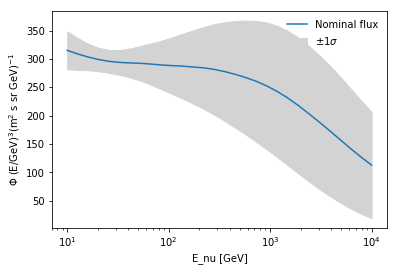

In [80]:
# 1D plot of the flux (averaged over angles)
plus_one_sigma = np.mean(sys_flux["numu"]+nom_flux["numu"], axis=1)*e_grid**mag # NB: sys_flux is +/- the nominal flux
minus_one_sigma = np.mean(-sys_flux["numu"]+nom_flux["numu"], axis=1)*e_grid**mag

zlabel = r"$\Phi$ (E/GeV)$^{" + str(mag) +" }$" + "(m$^{2}$ s sr GeV)$^{-1}$"

plt.figure()
plt.plot(e_grid, np.mean(nom_flux["numu"], axis=1)*e_grid**mag, label='Nominal flux')
plt.fill_between(e_grid, minus_one_sigma, plus_one_sigma, color='lightgrey', label =r'$\pm 1 \sigma$')
plt.legend(frameon=False)
plt.xlabel('E_nu [GeV]')
plt.ylabel(zlabel)
plt.xscale('log')

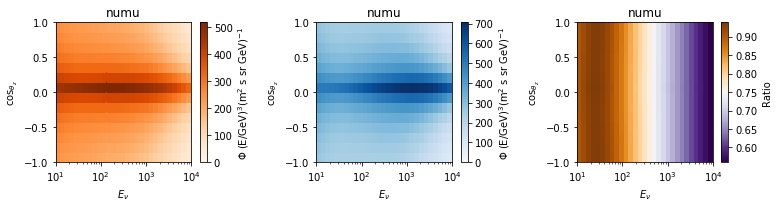

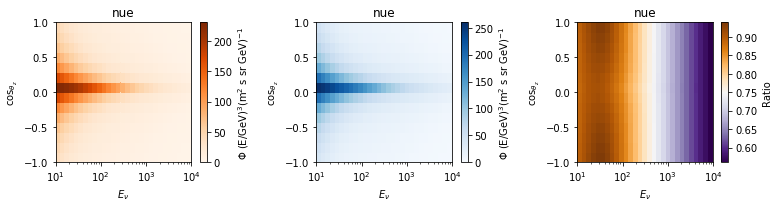

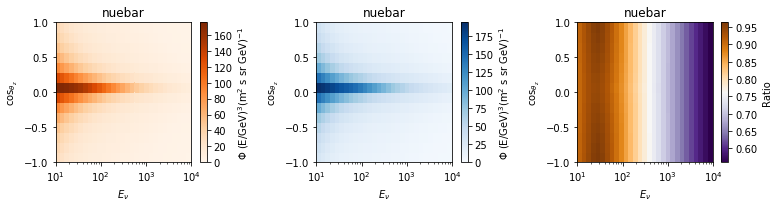

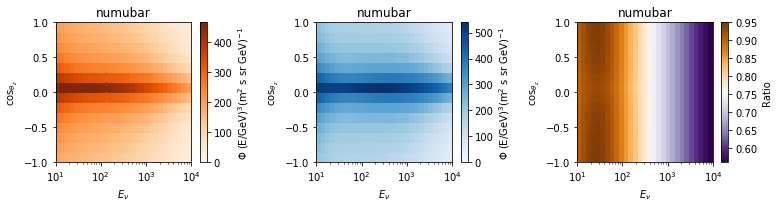

In [81]:
# 2D plot: left - nominal, middle - systematic flux: nominal + uncertainties of dictionary, right - ratio
for species in nom_flux.keys(): 
    fig, axes = plt.subplots(1, 3, figsize=(11,3))

    # nominal flux 
    cmesh_nom = axes[0].pcolormesh(E, coszen, nom_flux[species]*E**mag, cmap='Oranges', vmin=0)
    colorbar = fig.colorbar(cmesh_nom, ax=axes[0])
    colorbar.set_label(zlabel)
    
    # systematic flux (obs! only +1 sigma in contrast to the 1D plot)
    cmesh_sys = axes[1].pcolormesh(E, coszen, (nom_flux[species]+sys_flux[species])*E**mag, cmap='Blues', vmin=0)
    colorbar = fig.colorbar(cmesh_sys, ax=axes[1])
    colorbar.set_label(zlabel)
    
    ratio = nom_flux[species]/(nom_flux[species]+sys_flux[species])
    cmesh_ratio = axes[2].pcolormesh(E, coszen, ratio, cmap='PuOr_r')
    colorbar = fig.colorbar(cmesh_ratio, ax=axes[2])
    colorbar.set_label(r"Ratio")

    for ax in axes:
        ax.set_title(species)
        ax.set_xlabel(r'$E_\nu$')
        ax.set_ylabel(r'$\cos_{\theta_z}$')
        ax.set_xscale('log')
        
    plt.tight_layout()